In [1]:
%load_ext autoreload

In [2]:
%autoreload
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from tqdm.auto import tqdm
from jx.spatial import *
import cmdstanpy
import pears

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['figure.figsize'] = (11, 7)

# NYC

In [25]:
data = pd.read_csv('../data/nyc_subset_data.csv')
nyc_shp = gpd.read_file('../data/nycTracts10/nycTracts10.shp')
nyc_shp['GEOID10'] = nyc_shp['GEOID10'].astype(int)

In [26]:
geoids = nyc_shp['GEOID10'][nyc_shp['GEOID10'].isin(data['nyc_tractIDs'])]
nyc_shp_subset = nyc_shp[nyc_shp['GEOID10'].isin(geoids)].sort_values(by=['GEOID10']).reset_index().drop('index', 1)
df = nyc_shp_subset.merge(data, left_on='GEOID10', right_on='nyc_tractIDs')

In [49]:
df['pop_2001'][df['pop_2001'] < 10] = 10.

In [27]:
neighbours_list = geo_to_nb(df)

  0%|          | 0/1921 [00:00<?, ?it/s]

In [28]:
node1, node2 = nb_to_graph(neighbours_list)
sf = scaling_factor(node1, node2)

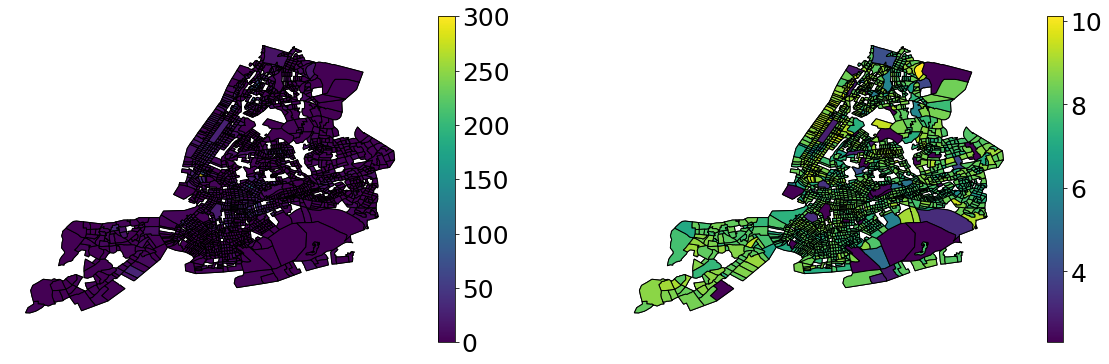

In [56]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(ax=ax1, edgecolor='k', color='white')
df.plot('events_2001', ax=ax1, edgecolor='k', legend=True)

df.plot(ax=ax2, edgecolor='k', color='white')
df.plot(np.log(df['pop_2001']), ax=ax2, edgecolor='k', legend=True)

for a in [ax1, ax2]:
    a.axis('off')

In [55]:
proxy = np.random.normal(df['events_2001'], df['events_2001'])

In [57]:
model = cmdstanpy.CmdStanModel(stan_file='../jx/stanmodels/counts.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [65]:
mask = ~df['events_2001'].isna()

data=dict(
    N = len(df),
    N_obs = mask.sum(),
    obs_idx = df.index,
    N_edges = node1.size,
    node1 = node1 + 1,
    node2 = node2 + 1,
    y = df['events_2001'][mask].astype(int),
    E = df['pop_2001'],
    x = proxy,
    scaling_factor=sf,
    # X1 = df['x'],
    # X2 = df['y'],
)

try:
    opt = model.optimize(data=data)
except:
    pass

sm = model.sample(data=data, iter_warmup=3000)


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [68]:
samples = sm.stan_variables()

In [78]:
samples = {k: np.concatenate((v[:1000], v[2000:])) for k, v in samples.items()}

(<Figure size 547.2x547.2 with 9 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='rho'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='beta0', ylabel='sigma'>,
         <AxesSubplot:xlabel='rho'>, <AxesSubplot:xlabel='sigma'>]],
       dtype=object))

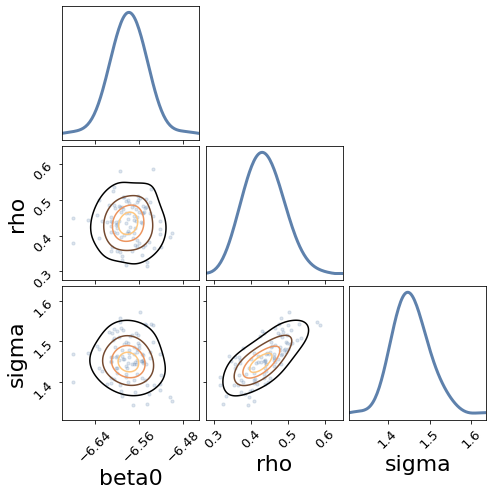

In [101]:
pears.pears(samples, indices=['beta0', 'rho', 'sigma'], scatter_thin=30)

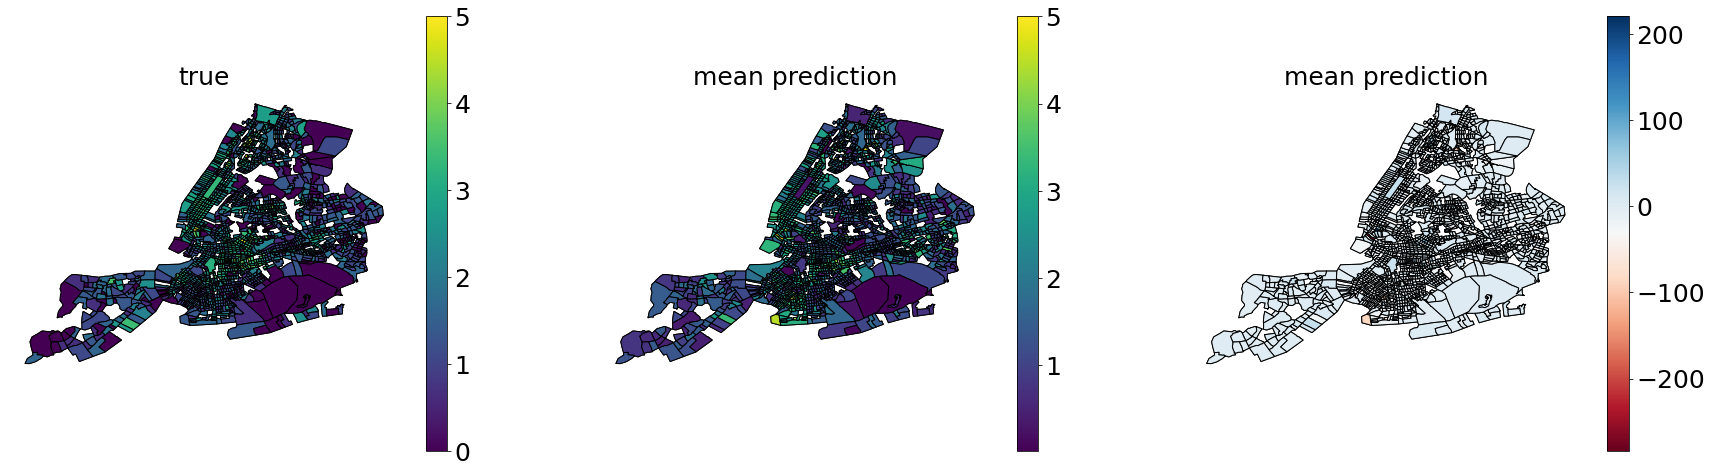

In [97]:
fig = plt.figure(figsize=(30, 8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

pred = sm.stan_variable('mu').mean(axis=0)
err = df['events_2001'] - pred
# norm = matplotlib.colors.CenteredNorm(halfrange=20)

df.plot(ax=ax1, edgecolor='k', color='white')
df.plot(np.log(df['events_2001'] + 1), ax=ax1, edgecolor='k', vmax=5, legend=True)
ax1.set_title('true')

df.plot(ax=ax2, edgecolor='k', color='white')
df.plot(np.log(pred + 1), ax=ax2, edgecolor='k', vmax=5, legend=True)
ax2.set_title('mean prediction')

df.plot(ax=ax3, edgecolor='k', color='white')
df.plot(err, ax=ax3, edgecolor='k', cmap='RdBu', legend=True)
ax3.set_title('mean prediction')

for a in [ax1, ax2, ax3]:
    a.axis('off')

In [98]:
df['pred'] = pred

In [106]:
df.explore('pop_2001')

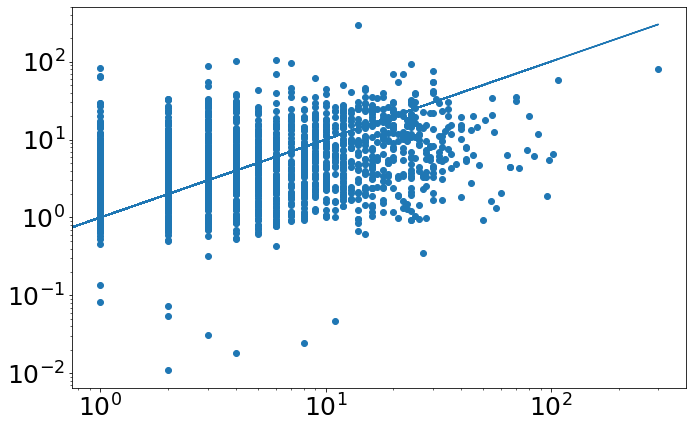

In [118]:
plt.scatter(df['events_2001'], samples['mu'].mean(axis=0))
plt.plot(df['events_2001'], df['events_2001'])
plt.xscale('log')
plt.yscale('log')

# Scotland

In [3]:
data = pd.read_csv('../data/scotland/scotland.csv')
scotland_shp = gpd.read_file('../data/scotland/scotland.shp')
data['geometry'] = scotland_shp['geometry']
df = gpd.GeoDataFrame(data)

In [4]:
node1, node2 = nb_to_graph(geo_to_nb(df))
sf = scaling_factor(node1, node2)

  0%|          | 0/56 [00:00<?, ?it/s]

<AxesSubplot:>

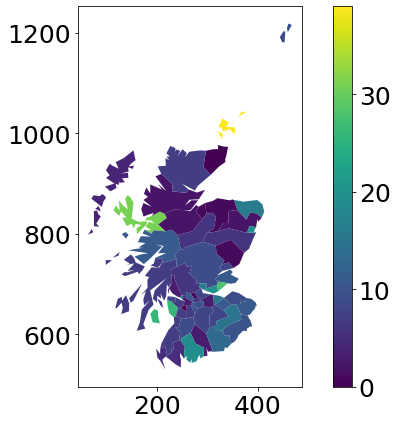

In [6]:
df.plot('cases', legend=True)

In [75]:
df['meas'] = df['cases']
randmiss = np.random.choice(np.arange(len(df)), size=int(0.5*len(df)), replace=False)
df['meas'][df.index.isin(randmiss)] = np.nan

In [89]:
mask = ~df['meas'].isna()

data = dict(
    N = len(df),
    N_obs = mask.sum(),
    obs_idx = df.index[mask] + 1,
    
    N_edges = node1.size,
    node1 = node1 + 1,
    node2 = node2 + 1,
    
    y = df['cases'][mask].to_numpy().astype(int),
    E = df['expected'].to_numpy(),
    x = df['AFF'].to_numpy(),
    
    scaling_factor=sf,
    
    X1=df['x'],
    X2=df['y'],
)
data['log_E'] = np.log(data['E'])

In [28]:
cmdstanpy.set_cmdstan_path('/home/js/.cmdstan/cmdstan-2.28.2/')

In [110]:
model = cmdstanpy.CmdStanModel(stan_file='../jx/stanmodels/counts_kriging.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [111]:
sm = model.sample(data=data, iter_warmup=4000, metric='dense')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [112]:
print(sm.diagnose())

Processing csv files: /tmp/tmpcahb222c/counts_kriging-20220426021959_1.csv, /tmp/tmpcahb222c/counts_kriging-20220426021959_2.csv, /tmp/tmpcahb222c/counts_kriging-20220426021959_3.csv, /tmp/tmpcahb222c/counts_kriging-20220426021959_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



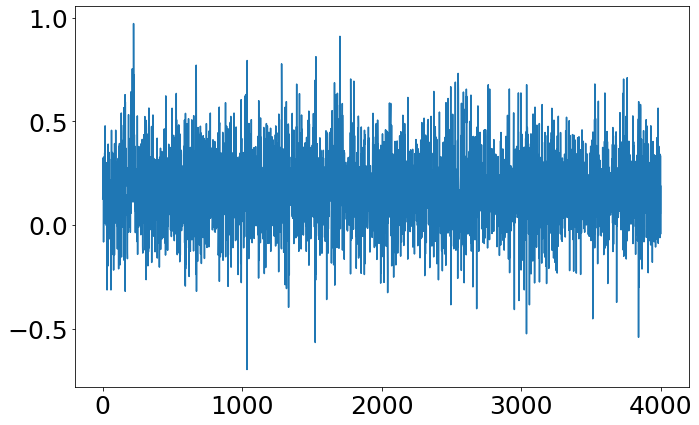

In [113]:
plt.plot(sm.stan_variable('beta0'));

In [114]:
samples = {k: v for k, v in sm.stan_variables().items()}

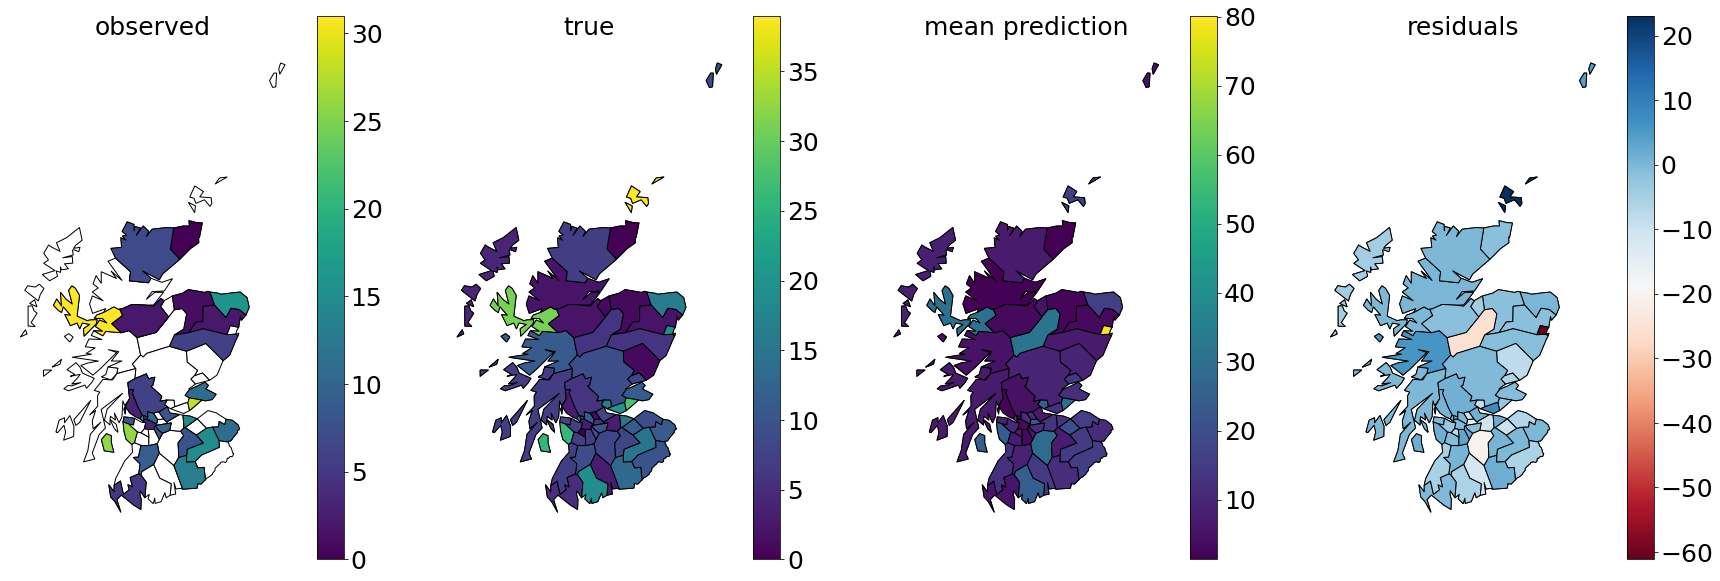

In [130]:
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

pred = samples['mu'].mean(axis=0)
pred[pred == np.inf] = np.nan
err = df['cases'] - pred
# norm = matplotlib.colors.CenteredNorm(halfrange=20)

df.plot(ax=ax1, edgecolor='k', color='white')
df.plot('meas', ax=ax1, edgecolor='k', legend=True)
ax1.set_title('observed')

df.plot(ax=ax2, edgecolor='k', color='white')
df.plot('cases', ax=ax2, edgecolor='k', legend=True)
ax2.set_title('true')

df.plot(ax=ax3, edgecolor='k', color='white')
df.plot(pred, ax=ax3, edgecolor='k', legend=True)
ax3.set_title('mean prediction')

df.plot(ax=ax4, edgecolor='k', color='white')
df.plot(err, ax=ax4, edgecolor='k', cmap='RdBu', legend=True)
ax4.set_title('residuals')

for a in [ax1, ax2, ax3, ax4]:
    a.axis('off')

In [137]:
df['cases']

0     31
1     16
2      0
3     11
4      2
5     39
6      1
7      9
8     11
9      2
10     4
11     7
12     1
13     5
14    11
15     6
16     6
17    15
18     2
19    10
20     1
21    19
22     7
23     8
24    28
25    20
26     3
27     9
28     9
29     3
30     9
31    19
32    11
33     6
34     7
35     8
36    26
37     6
38     3
39    17
40     7
41     8
42    16
43    10
44    15
45     7
46     7
47     9
48     3
49     8
50     1
51     5
52     0
53    11
54    13
55     8
Name: cases, dtype: int64

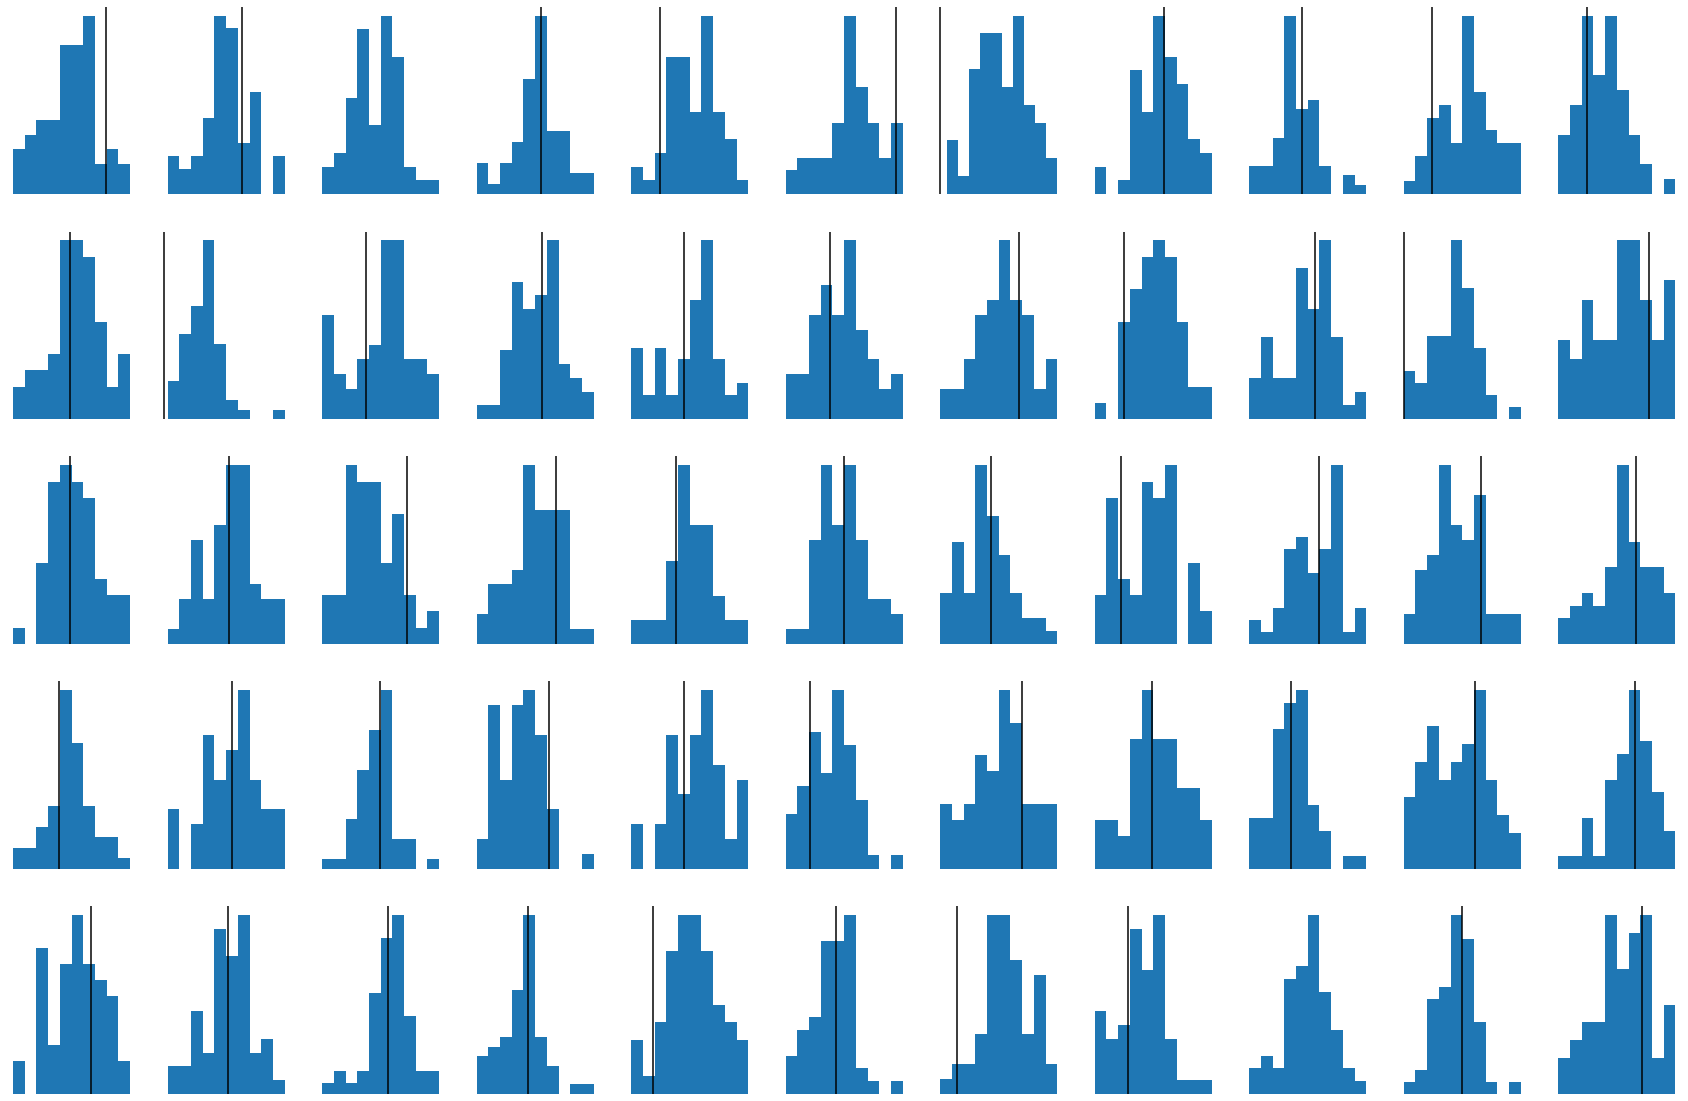

In [143]:
fig, ax = plt.subplots(5, 11, figsize=(30, 20))
for i in range(5):
    for j in range(11):
        ax[i,j].hist(np.log(samples['mu'][idx]))
        ax[i,j].axvline(np.log(df['cases'][idx]), c='k')
        ax[i,j].axis('off')